# I. Imports

In [4]:
import pandas as pd
import cv2
import os, shutil
import sys
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

import random as rd
from random import *

import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.python.keras.utils.np_utils import to_categorical

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras import Model, Sequential
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping

from sklearn.metrics import f1_score, confusion_matrix
from skimage.transform import resize

from utils.extractPatches import extract_patches 
import utils.helpers as helpers

# II. Constantes

In [5]:
# __original_dataset_path__ = "./DB/"
__original_dataset_path__ = "./data/DB/"
__train_path__ = __original_dataset_path__+'train/'
__test_path__ = __original_dataset_path__+'test/'
__val_path__ = __original_dataset_path__+'validation/'
# __video_path__ = 'VIDEOS'
# __bboxes_path__ = 'GT'
__bboxes_path__ = './data/GT'
__video_path__ = './data/VIDEOS'

# III. Fonctions

In [6]:
def show_rdm_img(directory):
    i = randint(0, len(directory))
    filename = directory.filepaths[i]
    path = filename.split("\\")[0]

    filename = filename.split("\\")[1]

    img = cv2.imread(os.path.join(path, filename))
    print(img[0][0])
    plt.imshow(img)


from random import randint
def generate_rdm_boxes_from_box(
    rect, delta_move, delta_taille, w_frame, h_frame, nb_box=30
):
    """
    Génère de nouveau rectangle aléatoirement autour du rectangle rect

    Args:
    - rect         : [ x coin haut gauche,
                       y coin haut gauche,
                       largeur,
                       hauteur  ]
    - delta_move   : déplacement maximum en translation normalisé par rapport à la taille du rect (max = 1)
    - delta_taille : redimensionnement maximal normalisé par rapport à la taille du rect (max = 1)
    - w_lim        : image width
    - h_lim        : image height
    - nb_box       : nombre de nouveau rectangle
    """

    x1, y1, w, h = rect
    x2 = x1 + w
    y2 = y1 + h

    delta_taille = min(delta_taille, 1)
    delta_move = min(delta_move, 1)

    w_delta = int(w * delta_move + w * delta_taille / 2)
    h_delta = int(h * delta_move + h * delta_taille / 2)

    rdm_bboxes = []

    while len(rdm_bboxes) < nb_box:
        n_x1 = x1 + randint(-w_delta, w_delta)
        n_y1 = y1 + randint(-h_delta, h_delta)
        n_x2 = x2 + randint(-w_delta, w_delta)
        n_y2 = y2 + randint(-h_delta, h_delta)

        if (
            n_x2 - n_x1 > w * (1 - delta_taille)
            and n_y2 - n_y1 > h * (1 - delta_taille)
            and n_x1 > 0
            and n_y1 > 0
            and n_x2 < w_frame
            and n_y2 < h_frame
        ):
            rdm_bboxes.append((n_x1, n_y1, n_x2 - n_x1, n_y2 - n_y1))

    return rdm_bboxes

    # step = max(int(max_dim / 8), 1)

    # # Génération de boîtes autour de la boîte de la frame précédente
    # for x_new in range(x_prev-delta_dist-delta_taille, x_prev+delta_dist,step) :
    #     for y_new in range(y_prev-delta_dist-delta_taille,y_prev+delta_dist,step) :
    #         if(x_new<w_frame and y_new <h_frame) :
    #             for w_new in range(w_prev-delta_taille, w_prev+delta_taille,step) :
    #                 for h_new in range(h_prev-delta_taille, h_prev+delta_taille,step) :
    #                     w_new = min(w_new,w_frame-x_new)
    #                     h_new = min(h_new,h_frame -y_new)
    #                     new_coords = (x_new,y_new,w_new,h_new)
    #                     # pour éviter d'avoir des ox de 5 pixels de hauteur ou largeurs qui seraient très petites
    #                     if(w_new > w_lim and h_new > h_lim) :
    #                         rdm_bboxes.append(new_coords)

    # print(len(rdm_bboxes))
    # # on sélectionne aléatoirement 30 box parmi celles générées
    # boxes = []
    # for _ in range(30):
    #     index = randint(0,len(rdm_bboxes))
    #     boxes.append(rdm_bboxes[index])

    # return boxes


In [7]:
def get_num_first_frame_with_coord(list_bbox_path):
    boxes = get_all_true_box(list_bbox_path)
    i = 0
    first = boxes[i]
    while first is None:
        i += 1
        first = boxes[i]
    return i, first


def get_all_true_box(list_bbox_path):
    boxes = []
    with open(list_bbox_path) as fp:
        lines = fp.readlines()
        for i, line in enumerate(lines):
            elts = line.split()
            if len(elts) == 2:
                assert elts[1] == "0"
                boxes.append(None)
            else:
                assert len(elts) > 2
                assert elts[1] == "1"  # only one bbox per frame
                assert i == (int)(elts[0])  # frame number
                x = (int)(elts[2])
                y = (int)(elts[3])
                w = (int)(elts[4])
                h = (int)(elts[5])
                boxes.append((x, y, w, h))
    return boxes


def get_frame_from_number(video_path, frame_nb):
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print("ERROR: unable to read video:", video_path)
        sys.exit()

    frame_number = 1
    _, frame = cap.read()
    while frame_number != frame_nb:
        frame_number += 1
        _, frame = cap.read()
    return frame


def get_nb_frames_video(video_path):
    cap = cv2.VideoCapture(video_path)
    length = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    return length


# IV. Récupération des données

### &nbsp;&nbsp;&nbsp;Création d'un dossier d'image de validation (executer une fois)

In [8]:
# __validation_proportion__ = 0.2

In [9]:
# for dirname in os.listdir(__train_path__) : 
#     print(f"Il y a {len(os.listdir(__train_path__+dirname))} images dans {dirname}")

Il y a 1019 images dans Bowl
Il y a 874 images dans CanOfCocaCola
Il y a 1024 images dans MilkBottle
Il y a 1032 images dans Rice
Il y a 787 images dans Sugar


In [ ]:
# __validation_path__ = os.path.join(__original_dataset_path__, 'validation/')
# os.mkdir(__validation_path__)

In [11]:
# for classe in os.listdir(__train_path__) : 
#     classe_path =  os.path.join(__validation_path__, classe+'/')
#     os.mkdir(classe_path)
#     len_validation = int(len(os.listdir(__train_path__+classe))*__validation_proportion__)
#     src_path = __train_path__+classe+'/'
#     dst_path = classe_path

#     for _ in range(len_validation) : 
#         rdm_filename = choice(os.listdir(__train_path__+classe+'/'))
#         src_path_complete = src_path + rdm_filename
#         dst_path_complete = dst_path + rdm_filename
#         shutil.copyfile(src_path_complete, dst_path_complete)
#         os.remove(src_path_complete)

### &nbsp;&nbsp;&nbsp;DataSets

In [14]:
from skimage.transform import resize
from tensorflow.keras.applications.vgg16 import preprocess_input
from cv2 import cvtColor, COLOR_BGR2RGB
def preprocess_image(img) : 
    
    img_rgb = cvtColor(img, COLOR_BGR2RGB)
    img_resize = resize(img_rgb, (227,227,3))
    return preprocess_input(img_resize)

    
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.python.keras.utils.np_utils import to_categorical
def get_datasets(train=True, val=True, test=True):


    generator = ImageDataGenerator(preprocessing_function=preprocess_input)

    resp = []

    if train:
        ## Train dataset
        print("Train:\t\t", end="")
        train_img = generator.flow_from_directory(
            directory=__train_path__, target_size=(227, 227), color_mode='rgb', classes=None,
            class_mode='categorical', batch_size=32, shuffle=True, seed=None,
            save_to_dir=None, save_prefix='', save_format='png',
            follow_links=False, interpolation='nearest'
        )
        assert train_img.num_classes == 5
        train_labels = to_categorical(train_img.classes)        
        resp.append(train_img)
        resp.append(train_labels)

    if val:
        ## Validation dataset
        print("Validation:\t", end="")
        val_img = generator.flow_from_directory(
            directory=__val_path__, target_size=(227, 227), color_mode='rgb', classes=None,
            class_mode='categorical', batch_size=32, shuffle=True, seed=None,
            save_to_dir=None, save_prefix='', save_format='png',
            follow_links=False, interpolation='nearest'
        )
        assert val_img.num_classes == 5
        val_labels = to_categorical(val_img.classes)        
        resp.append(val_img)
        resp.append(val_labels)

    if test:
        ## Test dataset
        print("Test:\t\t", end="")
        test_img = generator.flow_from_directory(
            directory=__test_path__, target_size=(227, 227), color_mode='rgb', classes=None,
            class_mode='categorical', batch_size=32, shuffle=False, seed=None,
            save_to_dir=None, save_prefix='', save_format='png',
            follow_links=False, subset=None, interpolation='nearest'
        )
        assert test_img.num_classes == 5
        test_labels = to_categorical(test_img.classes)
        resp.append(test_img)
        resp.append(test_labels)
    
    return resp

def get_labels():
    class_labels = os.listdir(__train_path__)
    return class_labels, len(class_labels)

In [15]:
train_img, train_labels, val_img, val_labels, test_img, test_labels = get_datasets()
class_labels, __nb_classes__ = get_labels()

Train:		Found 3792 images belonging to 5 classes.
Validation:	Found 944 images belonging to 5 classes.
Test:		Found 3568 images belonging to 5 classes.


### &nbsp;&nbsp;&nbsp;Visualisation des données

In [16]:
print(val_labels)
print("*"*25)
print(train_labels)
print("*"*25)
print(test_labels)

[[1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 ...
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]]
*************************
[[1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 ...
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]]
*************************
[[1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 ...
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]]


In [17]:
i = randint(0, len(val_img))
filename = val_img.filepaths[i]
path = filename.split("\\")[0]
    
filename = filename.split("\\")[1]

img = cv2.imread(os.path.join(path,filename))
print(img[0][0])
print(img.shape)

img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
print(img_rgb[0][0])
print(img_rgb.shape)

img_resize = resize(img_rgb, (227,227,3))
print(img_resize.shape)

preprocess_img = preprocess_input(img_resize)
print(preprocess_img.shape)


[ 66 126 183]
(227, 227, 3)
[183 126  66]
(227, 227, 3)
(227, 227, 3)
(227, 227, 3)


[ 72 125 176]
[44 56 95]
[100 151 214]


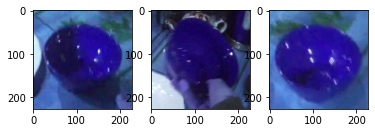

In [18]:
plt.subplot(131)
show_rdm_img(train_img)
plt.subplot(132)
show_rdm_img(val_img)
plt.subplot(133)
show_rdm_img(test_img)

In [19]:
test_img.__getitem__(0)
# 1er batch : (x,y) avec x tableau avec les images du batch, 
# et y tableau avec les labels corresp

(array([[[[ -69.939    ,  -86.779    ,  -97.68     ],
          [ -71.939    ,  -88.779    ,  -99.68     ],
          [ -69.939    ,  -89.779    ,  -99.68     ],
          ...,
          [ -45.939003 ,  -63.779    ,  -78.68     ],
          [ -49.939003 ,  -67.779    ,  -82.68     ],
          [ -47.939003 ,  -65.779    ,  -80.68     ]],
 
         [[ -70.939    ,  -88.779    ,  -96.68     ],
          [ -72.939    ,  -89.779    , -100.68     ],
          [ -71.939    ,  -91.779    , -101.68     ],
          ...,
          [ -44.939003 ,  -62.779    ,  -77.68     ],
          [ -45.939003 ,  -65.779    ,  -80.68     ],
          [ -46.939003 ,  -64.779    ,  -79.68     ]],
 
         [[ -72.939    ,  -90.779    ,  -98.68     ],
          [ -73.939    ,  -91.779    ,  -99.68     ],
          [ -71.939    ,  -92.779    ,  -99.68     ],
          ...,
          [ -42.939003 ,  -62.779    ,  -77.68     ],
          [ -45.939003 ,  -65.779    ,  -80.68     ],
          [ -46.939003 ,  -67.7

In [20]:
test_img.__len__()
# 112 batches de 32 images 

112

# V. Modèle de classification

In [21]:
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras import Model, Sequential
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping

__learning_rate__ = 1e-5
__epochs__ = 50
__x_shape__ = (227,227,3)

### a. Modele VGG

In [22]:
earlyStopping = EarlyStopping(monitor='val_accuracy', patience=5)
lr_reduce = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=5, verbose=1, mode='max', min_lr=__learning_rate__)
filepath="models/weights-improvement-{epoch:02d}-{val_accuracy:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath=filepath, monitor= 'val_accuracy', mode= 'max', save_best_only = True, verbose= 1)

baseModel = VGG16(weights='imagenet', include_top=False, input_shape=__x_shape__)
baseModel.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 227, 227, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 227, 227, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 227, 227, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 113, 113, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 113, 113, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 113, 113, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

### b. Finetuning

In [23]:
for layer in baseModel.layers[:15]:
	layer.trainable = False
	
x = baseModel.output
x = Flatten()(x) 
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = Dense(__nb_classes__, activation='softmax')(x)

finalModel= Model(inputs=baseModel.input, outputs=x)
finalModel.summary()

opt = Adam(learning_rate=__learning_rate__)
finalModel.compile(loss="categorical_crossentropy", optimizer = opt, metrics=["accuracy"])

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 227, 227, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 227, 227, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 227, 227, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 113, 113, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 113, 113, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 113, 113, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)      

In [ ]:
history = finalModel.fit(train_img, validation_data=val_img, epochs=__epochs__, callbacks=[lr_reduce, earlyStopping, checkpoint])

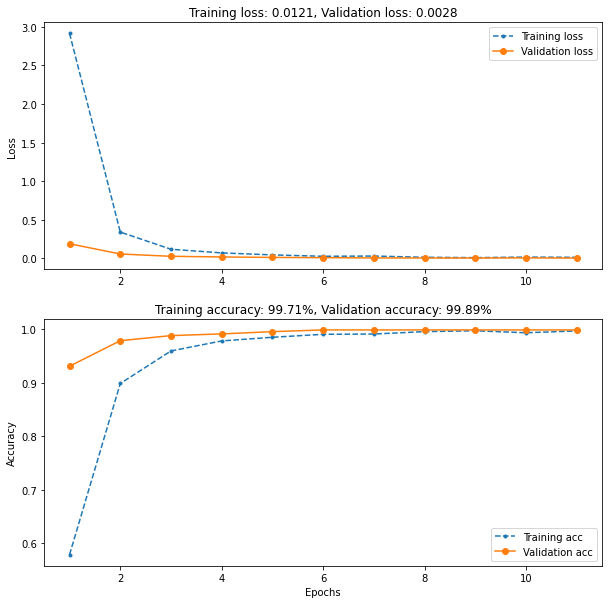

In [68]:
helpers.plot_loss_acc(history)

### c. Prédictions sur test

In [22]:
from tensorflow.keras import models
import numpy as np

In [67]:
# bon modèle avec input_shape = (227,227,3)
finalModel = models.load_model('models/vgg16_16_20_0.89.h5')
# finalModel = models.load_model('models\weights-improvement-06-1.00.hdf5')

In [26]:
test_img, y_test = get_datasets(train=False, val=False, test=True)
class_labels, _ = get_labels()

Test:		Found 3568 images belonging to 5 classes.


In [68]:
y_predict = finalModel.predict(test_img)

In [69]:
y_predict_binary = np.zeros_like(y_predict)
for index, y in enumerate(y_predict):
    y_predict_binary[index][np.argmax(y)] = 1

0.9022315080589294


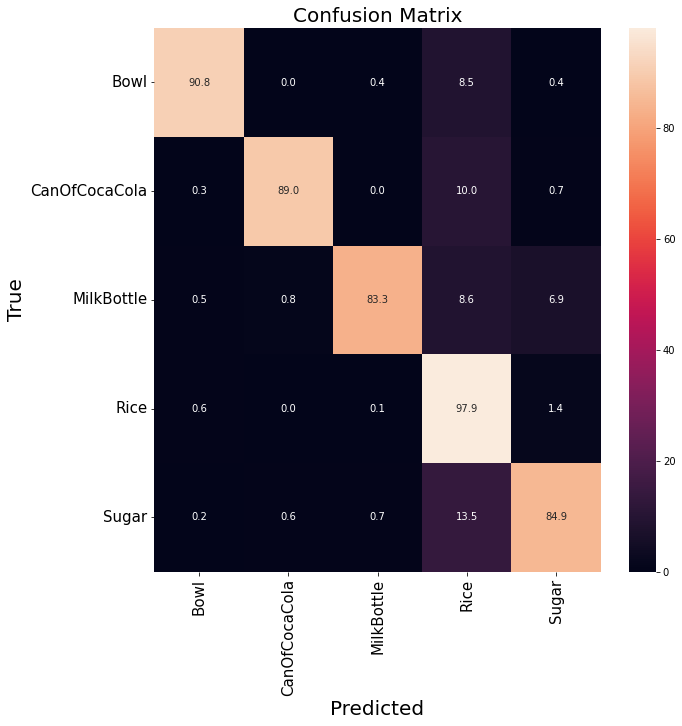

In [70]:
from sklearn.metrics import f1_score

print(f1_score(y_test, y_predict_binary, average="macro"))
helpers.plot_multiclass_heatmap(y_test, y_predict_binary, class_labels, figsize=(10,10))

**Commentaire** : on est plutôt satisfait car on a les plus hautes valeurs sur la diagonales, ce qui signifie que notre modèle a de bonnes prédictions. Cependant, d'autres valeurs autres que sur la diagonale sortent un peu du lot.
Par exemple, le sucre est détecté en temps que bouteille de lait dans 12.4% des cas, et le riz est détecté en tant que bouteille de lait dans 9,4% des cas.

**TODO** : essayer d'afficher les images pour lesquelles les prédictions sont les + mauvaises pour les analyser

### d. Prédictions sur de image rdm

In [28]:
from tensorflow.keras import models
import numpy as np
from random import randint
import os
import random as rd
import cv2
import matplotlib.pyplot as plt
import utils.helpers as helpers

#finalModel = models.load_model('models\weights-improvement-06-1.00.hdf5')
finalModel=models.load_model('models/vgg16_a__9.h5')

In [31]:
# rdm_video_filename = rd.choice(os.listdir(__video_path__))
rdm_video_filename = "CanOfCocaColaPlace2Subject4.mp4"
rdm_video_path = os.path.join(__video_path__, rdm_video_filename)

list_bbox_filename = rdm_video_filename.split('.')[0] +"_2_bboxes.txt"
list_bbox_path = os.path.join(__bboxes_path__,list_bbox_filename)

num_first_frame_with_coord  = get_num_first_frame_with_coord(list_bbox_path)

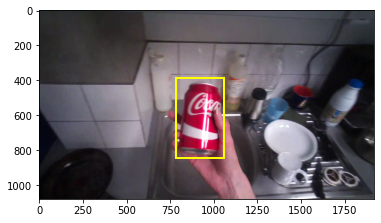

In [32]:
# rdm_index_frame = randint(num_first_frame_with_coord[0], get_nb_frames_video(rdm_video_path))
rdm_index_frame = 164
a_frame = get_frame_from_number(rdm_video_path, rdm_index_frame)
true_box = get_all_true_box(list_bbox_path)[rdm_index_frame]

%matplotlib inline
plt.imshow(cv2.cvtColor(a_frame, cv2.COLOR_BGR2RGB))
helpers.plt_box(plt, rect=true_box)

rdm_boxes = generate_rdm_boxes_from_box(true_box, 0.2, 0.2, a_frame.shape[1], a_frame.shape[0], 32)
rdm_img = np.array([preprocess_image(a_frame[box[1] : box[1] + box[3], box[0] : box[0] + box[2]]) for box in rdm_boxes])

In [33]:
prediction = finalModel.predict((rdm_img))

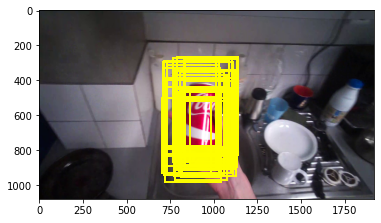

In [34]:
plt.imshow(cv2.cvtColor(a_frame, cv2.COLOR_BGR2RGB))
for i, box in enumerate(rdm_boxes):
    helpers.plt_box(plt, rect=(box[0],box[1],box[2],box[3]), linewidth=max(prediction[i][1]*2, 0))

C:\Users\aarthuis\.conda\envs\analyse_video\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


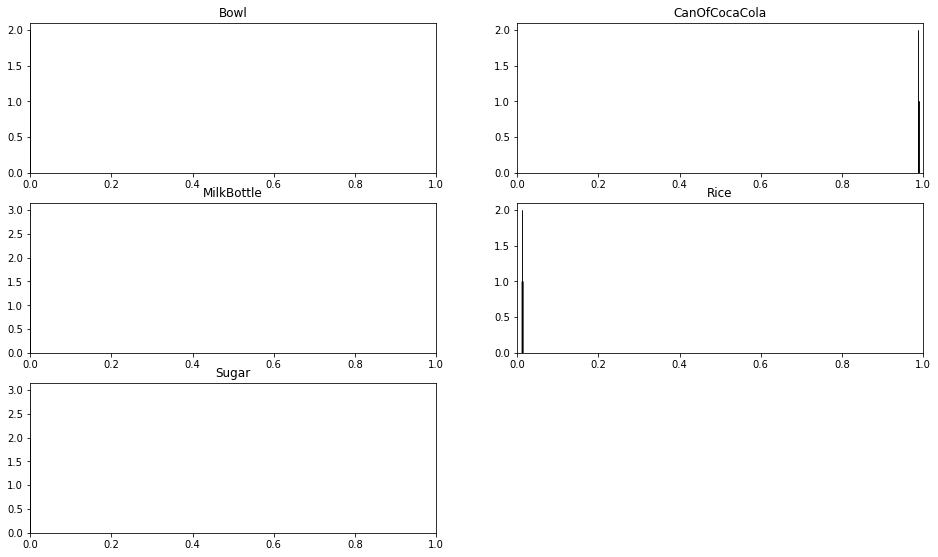

In [36]:
import seaborn as sns
class_labels, _ = get_labels()

plt.figure(figsize=(16,16))


proba = [0]*5
for i in range(len(class_labels)):
    proba[i] = [pr[i] for pr in prediction]


# pred = pred.reshape(5, 32)
for i, label in enumerate(class_labels):
    plt.subplot(521+i)
    sns.distplot(proba[i], hist=True, kde=False, 
                bins=100, color = 'blue',
                hist_kws={'edgecolor':'black'})
    plt.xlim(0, 1)
    plt.title(label)

In [37]:
print(rdm_video_filename, rdm_index_frame)

CanOfCocaColaPlace2Subject4.mp4 164


# VI. Traitement de la vidéo

## 1. Récupération de la boîte englobante de début

In [38]:
import random as rd
import matplotlib.pyplot as plt
import utils.helpers as helpers
import cv2
import os

In [39]:
rdm_video_filename = rd.choice(os.listdir(__video_path__))
rdm_video_path = os.path.join(__video_path__, rdm_video_filename)

list_bbox_filename = rdm_video_filename.split('.')[0] +"_2_bboxes.txt"
list_bbox_path = os.path.join(__bboxes_path__,list_bbox_filename)

num_first_frame_with_coord  = get_num_first_frame_with_coord(list_bbox_path)
print(f"La première frame de la vidéo {rdm_video_filename} où l'objet apparaît est la n°{num_first_frame_with_coord[0]}, les coordonnées de la boîte sont : {num_first_frame_with_coord[1]} ")

La première frame de la vidéo BowlPlace1Subject2.mp4 où l'objet apparaît est la n°70, les coordonnées de la boîte sont : (538, 202, 126, 110) 


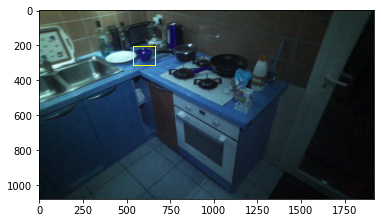

In [40]:
first_frame = get_frame_from_number(rdm_video_path, num_first_frame_with_coord[0])
plt.imshow(first_frame)
box_first_frame_coords = num_first_frame_with_coord[1]
helpers.plt_box(plt, rect=box_first_frame_coords, linewidth=1)

## 2. Récupération de la frame suivante et génération de boîtes aléatoires

plot 100


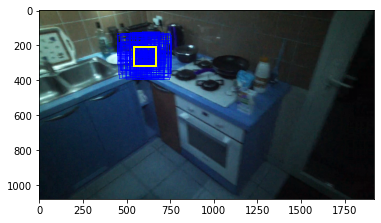

In [41]:
# On récupère la frame d'après
num_next_frame = num_first_frame_with_coord[0] + 1
next_frame = get_frame_from_number(rdm_video_path, num_next_frame)
rdm_boxes = generate_rdm_boxes_from_box(box_first_frame_coords,0.5,0.5,next_frame.shape[1],next_frame.shape[0],100)
all_true_boxes = get_all_true_box(list_bbox_path)

print('plot', len(rdm_boxes))
plt.imshow(next_frame)
for box in rdm_boxes:
    helpers.plt_box(plt, rect=box, linewidth=0.5, color="blue")
helpers.plt_box(plt, rect=all_true_boxes[num_next_frame])

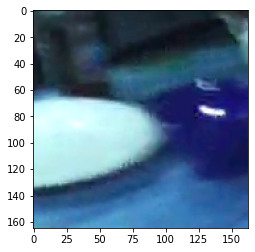

In [42]:
rdm_index = rd.randint(0,len(rdm_boxes)-1)
box = rdm_boxes[rdm_index]
img = next_frame[box[1]:box[1]+box[3],box[0]:box[0]+box[2]]
plt.imshow(img)

## 3. Généralisation

In [43]:
import numpy as np
from tensorflow.keras import models
import seaborn as sns

In [13]:
finalModel = models.load_model('models\weights-improvement-06-1.00.hdf5')

In [14]:
%matplotlib qt

In [44]:
"""
Dans cette cellule les images apparaissent dans une autre fenêtre
il faut appuyer sur une touche du clavier pour passer à l'image suivante
"""

from importlib import reload
reload(helpers)


from copy import deepcopy
__batch_size__ = 32
class_labels, _ = get_labels()
cv2.destroyAllWindows()

pred_boxes = []
num_first_frame, coords_first_box = get_num_first_frame_with_coord(list_bbox_path)
pred_boxes.append(coords_first_box)

cap = cv2.VideoCapture(rdm_video_path)
if not cap.isOpened():
    print("ERROR: unable to read video:", rdm_video_path)
    sys.exit()

label = rdm_video_filename.split("Place")[0]
label_id = class_labels.index(label)
print(label, label_id, class_labels)

fig, axs = plt.subplots(3, 2)

i = 0
while cap.isOpened():
    ret, frame = cap.read()
    if ret == False:
        break

    if i > num_first_frame:
        newBoxes = generate_rdm_boxes_from_box(
            pred_boxes[-1],
            0.6,
            0.6,
            frame.shape[1],
            frame.shape[0],
            nb_box=__batch_size__,
        )

        batch_imgs = []
        img_to_show = deepcopy(frame)
        for j, box in enumerate(newBoxes):
            img = frame[box[1] : box[1] + box[3], box[0] : box[0] + box[2]]
            # s = f"object{j}"
            # cv2.imshow(s, img)
            helpers.draw_box_in_matrix(img_to_show, box, linewidth=1)
            cv2.imshow("Detection", cv2.resize(img_to_show, (960, 540)))
            cv2.waitKey(1)
            
            batch_imgs.append(preprocess_image(img))

        batch_imgs = np.array(batch_imgs)
        model_prediction_batch = finalModel.predict((batch_imgs))

        proba = np.array(model_prediction_batch).reshape(len(class_labels), __batch_size__)

        # for i, label in enumerate(class_labels): 
        #     axs[i//2, i%2].hist(proba[i], bins=20)
        #     axs[i//2, i%2].set_title(label)

        # plt.show()

        print(len(proba[label_id]), len(newBoxes))
        bestBox = newBoxes[np.argmax(proba[label_id])]
        helpers.draw_box_in_matrix(img_to_show, bestBox, color=(0,0,255))
        cv2.imshow("Detection", cv2.resize(img_to_show, (960, 540)),)
        print("\r",f"Frame: {i}", max(proba[label_id]), end="")
        key =  cv2.waitKey(10)
        while key == -1:
             key = cv2.waitKey(10)

        pred_boxes.append(bestBox)

    i += 1

    # for num_box,box in enumerate(newBoxes) :
    #     if ((len(batch_imgs) < __batch_size__) and num_box < len(newBoxes)) :
    #         # img = frame[box[1]:box[1]+box[3],box[0]:box[0]+box[2]]
    #         img = frame[box[0]:box[0]+box[2],box[1]:box[1]+box[3]]
    #         print(img.shape)
    #         img_pre = preprocess_image(img)
    #         batch_imgs.append(img_pre)

    #     else:
    #         batch_imgs = np.array(batch_imgs)
    #         model_prediction_batch = finalModel.predict((batch_imgs))
    #         for pred in model_prediction_batch :
    #             proba.append(pred[label_id])
    #         batch_imgs = []


Bowl 0 ['Bowl', 'CanOfCocaCola', 'MilkBottle', 'Rice', 'Sugar']
32 32
 Frame: 71 0.9882859632 32
 Frame: 72 0.988189132 32
 Frame: 73 0.988153432 32
 Frame: 74 0.988154932 32
 Frame: 75 0.98914632 32
 Frame: 76 0.9887484332 32
 Frame: 77 0.9890597

In [73]:
cv2.destroyAllWindows()

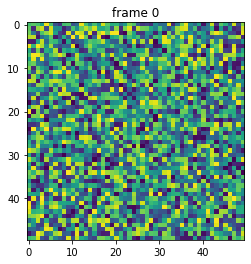

In [38]:
# import matplotlib.pyplot as plt
# import numpy as np

# np.random.seed(19680801)
# data = np.random.random((50, 50, 50))

# fig, ax = plt.subplots()

# for i in range(len(data)):
#     ax.cla()
#     ax.imshow(data[i])
#     ax.set_title("frame {}".format(i))
#     # Note that using time.sleep does *not* work here!
#     plt.pause(0.1)

In [49]:
frames_with_obj = [get_frame_from_number(rdm_video_path, i) for i in range(get_nb_frames_video(rdm_video_path)) if i >= num_first_frame]

In [50]:
assert(len(frames_with_obj) == len(pred_boxes))

In [52]:
import cv2
import os


for idx,frame_with_obj in enumerate(frames_with_obj) : 
    # frame = cv2.imread(frame_with_obj, 1)
    start_point= (pred_boxes[0],pred_boxes[1])
    end_point = (pred_boxes[0]+pred_boxes[2],pred_boxes[1]+pred_boxes[3])
    img_to_show = cv2.rectangle(frame_with_obj, start_point, end_point, (255,0,0), 2) 
    
    cv2.imshow('window', img_to_show)  

    key = cv2.waitKey(3000)#pauses for 3 seconds before fetching next image
    if key == 27:#if ESC is pressed, exit loop
        cv2.destroyAllWindows()
        break



# folder_path = __train_path__+'/Bowl'

# for path in os.listdir(folder_path):#loop to read one image at a time 
#     imgpath = os.path.join(folder_path, path)

#     frame = cv2.imread(imgpath, 1)

#     # start_point = (box_first_frame_coords[0], box_first_frame_coords[1])
#     # end_point = (box_first_frame_coords[0]+box_first_frame_coords[2], box_first_frame_coords[1]+box_first_frame_coords[3])
#     start_point= (10,10)
#     end_point = (15,15)
#     img_to_show = cv2.rectangle(frame, start_point, end_point, (255,0,0), 2) 
    
#     cv2.imshow('window', img_to_show)  

#     key = cv2.waitKey(3000)#pauses for 3 seconds before fetching next image
#     if key == 27:#if ESC is pressed, exit loop
#         cv2.destroyAllWindows()
#         break


error: OpenCV(4.5.4) :-1: error: (-5:Bad argument) in function 'rectangle'
> Overload resolution failed:
>  - Can't parse 'pt1'. Sequence item with index 0 has a wrong type
>  - Can't parse 'pt1'. Sequence item with index 0 has a wrong type
>  - Can't parse 'rec'. Expected sequence length 4, got 2
>  - Can't parse 'rec'. Expected sequence length 4, got 2


In [112]:
# # code de base : ne pas toucher
# pred_boxes = []
# num_first_frame, coords_first_box = get_num_first_frame_with_coord(list_bbox_path)
# pred_boxes.append(coords_first_box)

# cap = cv2.VideoCapture(rdm_video_path)
# if (not cap.isOpened()):
#     print("ERROR: unable to read video:", rdm_video_path)
#     sys.exit()

# label = rdm_video_filename.split('Place')[0]
# label_id = class_labels.index(label)

# i = 0
# while cap.isOpened():
#     ret, frame = cap.read()
#     if ret == False:
#         break
    
#     if i > num_first_frame:
#         newBoxes = generate_rdm_boxes_from_box(pred_boxes[-1], 50,50,frame.shape[1],frame.shape[0])
#         proba = []

#         for box in newBoxes:
#             img = frame[box[1]:box[1]+box[3],box[0]:box[0]+box[2]]
#             img_pre = preprocess_image(img)
#             model_prediction = finalModel.predict((img_pre))
#             proba.append(model_prediction[label_id])
        
#         bestBox = newBoxes[np.argmax(proba)]
#         pred_boxes.append(bestBox)
    
#     i+=1

ValueError: in user code:

    File "C:\Users\ema00\anaconda3\envs\3a_video_proj\lib\site-packages\keras\engine\training.py", line 1621, in predict_function  *
        return step_function(self, iterator)
    File "C:\Users\ema00\anaconda3\envs\3a_video_proj\lib\site-packages\keras\engine\training.py", line 1611, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\ema00\anaconda3\envs\3a_video_proj\lib\site-packages\keras\engine\training.py", line 1604, in run_step  **
        outputs = model.predict_step(data)
    File "C:\Users\ema00\anaconda3\envs\3a_video_proj\lib\site-packages\keras\engine\training.py", line 1572, in predict_step
        return self(x, training=False)
    File "C:\Users\ema00\anaconda3\envs\3a_video_proj\lib\site-packages\keras\utils\traceback_utils.py", line 67, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\ema00\anaconda3\envs\3a_video_proj\lib\site-packages\keras\engine\input_spec.py", line 263, in assert_input_compatibility
        raise ValueError(f'Input {input_index} of layer "{layer_name}" is '

    ValueError: Input 0 of layer "model_1" is incompatible with the layer: expected shape=(None, 227, 227, 3), found shape=(None, 227, 3)
